# Series temporales y data streams

Para el desarrollo del proyecto se ha seleccionado el dataset de GHCN-M (Global Historial Climatology Network - Monthly), que contiene datos de temperatura media mensual de estaciones meteorol√≥gicas de todo el mundo. Este dataset es ampliamente utilizado en estudios clim√°ticos y meteorol√≥gicos, y proporciona una base s√≥lida para el an√°lisis de series temporales.

## Preguntas a responder
1. ¬øC√≥mo ha evolucionado la temperatura mensual en distintas zonas del planeta desde 1880?
2. ¬øSe puede detectar una tendencia global al alza (calentamiento global) en ciertas latitudes?
3. ¬øCu√°les son las zonas que han experimentado mayor variabilidad o cambio?
4. ¬øPodemos predecir las temperaturas futuras en zonas espec√≠ficas?
5. ¬øC√≥mo se comportan los modelos en flujos de datos simulados con cambios de concepto?

Usaremos el dataset de temperatura mensual de la red GHCN-M de NOAA, que contiene datos tipo panel (por regi√≥n latitudinal-longitudinal).

### Carga y preprocesado del dataset

In [50]:
import pandas as pd
import numpy as np

# Carga del dataset
df = pd.read_csv('./data/ghcn-m-v1.csv')

# Reemplazo de valores nulos (-9999) por NaN
df = df.replace(-9999, np.nan)

# Visualizaci√≥n de la estructura b√°sica del dataset
print(df.shape)
df.head()

(59223, 75)


year  month     lat  lon_175_180W  lon_170_175W  lon_165_170W  \
0  1880      1  85-90N           NaN           NaN           NaN   
1  1880      1  80-85N           NaN           NaN           NaN   
2  1880      1  75-80N           NaN           NaN           NaN   
3  1880      1  70-75N           NaN           NaN           NaN   
4  1880      1  65-70N           NaN           NaN           NaN   

   lon_160_165W  lon_155_160W  lon_150_155W  lon_145_150W  ...  lon_130_135E  \
0           NaN           NaN           NaN           NaN  ...           NaN   
1           NaN           NaN           NaN           NaN  ...           NaN   
2           NaN           NaN           NaN           NaN  ...           NaN   
3           NaN           NaN           NaN           NaN  ...           NaN   
4           NaN           NaN           NaN           NaN  ...           NaN   

   lon_135_140E  lon_140_145E  lon_145_150E  lon_150_155E  lon_155_160E  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   
3           NaN           NaN           NaN           NaN           NaN   
4           NaN           NaN           NaN           NaN           NaN   

   lon_160_165E  lon_165_170E  lon_170_175E  lon_175_180E  
0           NaN           NaN           NaN           NaN  
1           NaN           NaN           NaN           NaN  
2           NaN           NaN           NaN           NaN  
3           NaN           NaN           NaN           NaN  
4           NaN           NaN           NaN           NaN  

[5 rows x 75 columns]

### Conversi√≥n de columnas a formato long (panel)

In [51]:
# Convertir de wide a long (una columna por celda lat/long)
df_long = df.melt(id_vars=["year", "month", "lat"], var_name="lon", value_name="temperatura")

# Crear la fecha correctamente usando year y month del dataset
df_long["fecha"] = pd.to_datetime(df_long[["year", "month"]].assign(day=1))

# Convertir lat y lon a string para el pivot
df_long["lat"] = df_long["lat"].astype(str)
df_long["lon"] = df_long["lon"].astype(str)

# Convertir a formato de panel
df_panel = df_long.pivot_table(index="fecha", columns=["lat", "lon"], values="temperatura")

# Visualizaci√≥n de la estructura del panel
df_panel.head()

lat            0-5N                                                  \
lon        lon_0_5E lon_0_5W lon_100_105E lon_100_105W lon_105_110E   
fecha                                                                 
1880-01-01      NaN      NaN        -13.0          NaN         33.0   
1880-02-01      NaN    -75.0          2.0          NaN         47.0   
1880-03-01      NaN      NaN        -27.0          5.0         19.0   
1880-04-01      NaN      NaN        -34.0          NaN          8.0   
1880-05-01      NaN      NaN        -29.0          NaN         13.0   

lat                                                                      ...  \
lon        lon_105_110W lon_10_15E lon_10_15W lon_110_115E lon_110_115W  ...   
fecha                                                                    ...   
1880-01-01          NaN        NaN      -52.0         -3.0       -138.0  ...   
1880-02-01         -1.0        NaN      -59.0          9.0        -45.0  ...   
1880-03-01        -17.0        NaN      -71.0        -23.0        -34.0  ...   
1880-04-01          NaN        NaN     -153.0        -43.0          NaN  ...   
1880-05-01          NaN        NaN      -72.0        -48.0          NaN  ...   

lat            85-90S                                        90-95S  \
lon        lon_75_80W lon_80_85W lon_85_90W lon_90_95W lon_110_115E   
fecha                                                                 
1880-01-01        NaN        NaN        NaN        NaN          NaN   
1880-02-01        NaN        NaN        NaN        NaN          NaN   
1880-03-01        NaN        NaN        NaN        NaN          NaN   
1880-04-01        NaN        NaN        NaN        NaN          NaN   
1880-05-01        NaN        NaN        NaN        NaN          NaN   

lat                                                         95-100S  
lon        lon_140_145E lon_35_40E lon_60_65E lon_75_80E lon_10_15E  
fecha                                                                
1880-01-01          NaN        NaN        NaN        NaN        NaN  
1880-02-01          NaN        NaN        NaN        NaN        NaN  
1880-03-01          NaN        NaN        NaN        NaN        NaN  
1880-04-01          NaN        NaN        NaN        NaN        NaN  
1880-05-01          NaN        NaN        NaN        NaN        NaN  

[5 rows x 2297 columns]

## An√°lisis exploratorio y visualizaci√≥n

### An√°lisis b√°sico por regiones (descriptiva general)

In [52]:
# Estad√≠sticas generales por celda lat/lon
desc = df_panel.describe().T.sort_values("mean", ascending=False)
desc.head(10)  # 10 celdas m√°s c√°lidas de media

count   mean  std    min    25%    50%    75%    max
lat     lon                                                               
80-85S  lon_140_145E    1.0  157.0  NaN  157.0  157.0  157.0  157.0  157.0
95-100S lon_10_15E      1.0  140.0  NaN  140.0  140.0  140.0  140.0  140.0
80-85S  lon_145_150E    1.0  139.0  NaN  139.0  139.0  139.0  139.0  139.0
        lon_130_135E    1.0  126.0  NaN  126.0  126.0  126.0  126.0  126.0
        lon_150_155E    1.0  111.0  NaN  111.0  111.0  111.0  111.0  111.0
90-95S  lon_140_145E    1.0  110.0  NaN  110.0  110.0  110.0  110.0  110.0
75-80S  lon_140_145E    1.0  107.0  NaN  107.0  107.0  107.0  107.0  107.0
80-85S  lon_120_125W    1.0  102.0  NaN  102.0  102.0  102.0  102.0  102.0
        lon_115_120W    1.0  100.0  NaN  100.0  100.0  100.0  100.0  100.0
75-80S  lon_135_140E    1.0   99.0  NaN   99.0   99.0   99.0   99.0   99.0

In [53]:
# Verificar las columnas disponibles en df_panel
print("Primeras 10 columnas (lat, lon) del DataFrame:")
print(df_panel.columns[:10].tolist())
print("\n√öltimas 10 columnas (lat, lon) del DataFrame:")
print(df_panel.columns[-10:].tolist())
print(f"\nTotal de columnas: {len(df_panel.columns)}")

# Verificar latitudes √∫nicas
latitudes = [col[0] for col in df_panel.columns]
print(f"\nLatitudes √∫nicas: {sorted(set(latitudes))}")

# Verificar longitudes √∫nicas
longitudes = [col[1] for col in df_panel.columns]
print(f"\nPrimeras 10 longitudes: {sorted(set(longitudes))[:10]}")

Primeras 10 columnas (lat, lon) del DataFrame:
[('0-5N', 'lon_0_5E'), ('0-5N', 'lon_0_5W'), ('0-5N', 'lon_100_105E'), ('0-5N', 'lon_100_105W'), ('0-5N', 'lon_105_110E'), ('0-5N', 'lon_105_110W'), ('0-5N', 'lon_10_15E'), ('0-5N', 'lon_10_15W'), ('0-5N', 'lon_110_115E'), ('0-5N', 'lon_110_115W')]

√öltimas 10 columnas (lat, lon) del DataFrame:
[('85-90S', 'lon_75_80W'), ('85-90S', 'lon_80_85W'), ('85-90S', 'lon_85_90W'), ('85-90S', 'lon_90_95W'), ('90-95S', 'lon_110_115E'), ('90-95S', 'lon_140_145E'), ('90-95S', 'lon_35_40E'), ('90-95S', 'lon_60_65E'), ('90-95S', 'lon_75_80E'), ('95-100S', 'lon_10_15E')]

Total de columnas: 2297

Latitudes √∫nicas: ['0-5N', '0-5S', '10-15N', '10-15S', '100-105S', '15-20N', '15-20S', '20-25N', '20-25S', '25-30N', '25-30S', '30-35N', '30-35S', '35-40N', '35-40S', '40-45N', '40-45S', '45-50N', '45-50S', '5-10N', '5-10S', '50-55N', '50-55S', '55-60N', '55-60S', '60-65N', '60-65S', '65-70N', '65-70S', '70-75N', '70-75S', '75-80N', '75-80S', '80-85N', '80-85S'

### Visualizaci√≥n de series individuales

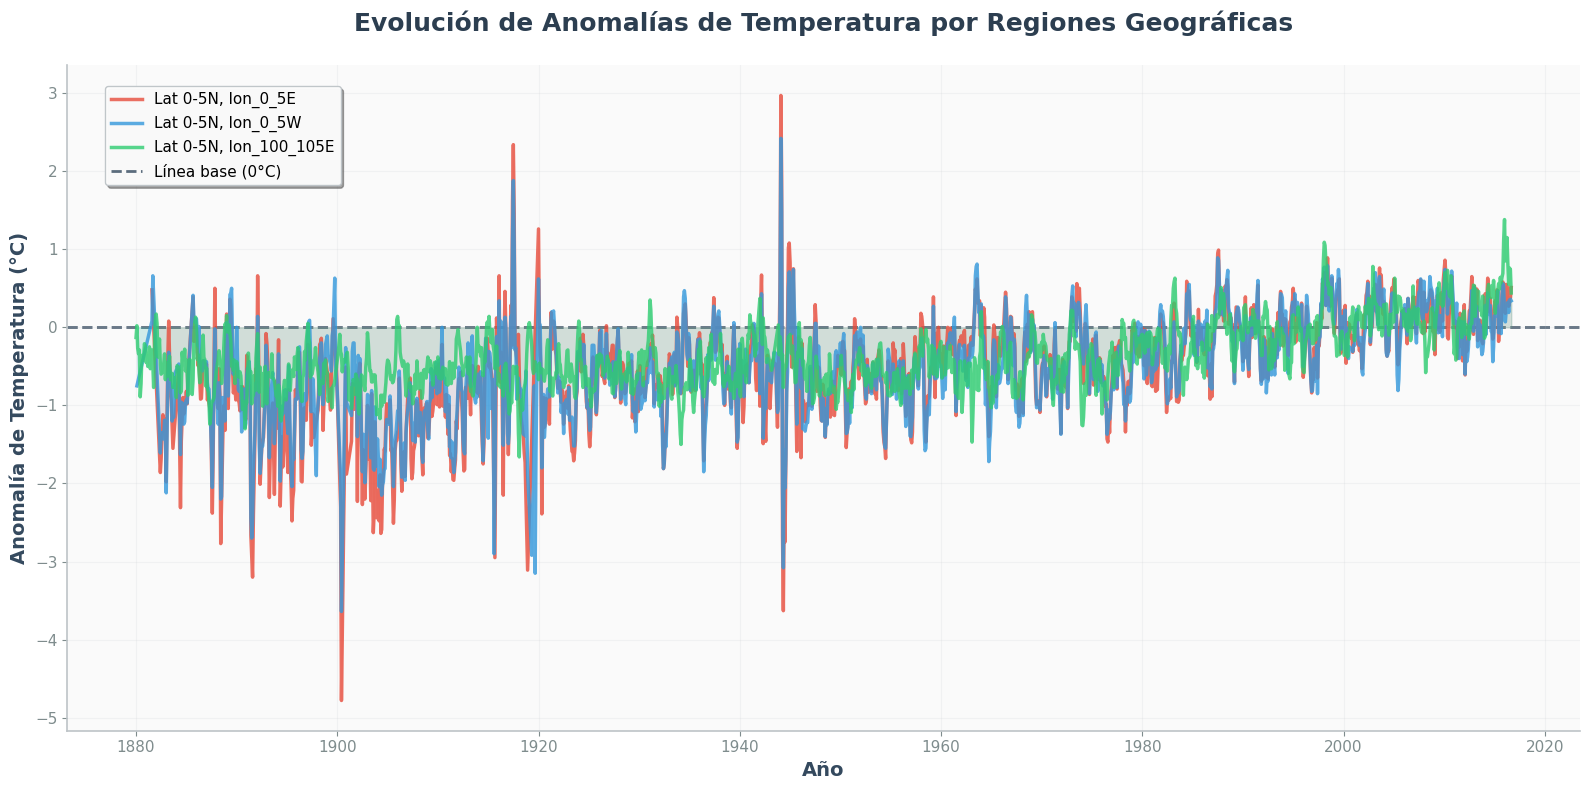

üåç Estad√≠sticas de anomal√≠as de temperatura por regi√≥n:
üìç Lat 0-5N, lon_0_5E:
   ‚Ä¢ Rango: -4.78¬∞C a 2.97¬∞C
   ‚Ä¢ Media: -0.51¬∞C
   ‚Ä¢ Desviaci√≥n est√°ndar: 0.68¬∞C
   ‚Ä¢ Tendencia reciente (√∫ltimos 30 a√±os): 0.09¬∞C

üìç Lat 0-5N, lon_0_5W:
   ‚Ä¢ Rango: -3.64¬∞C a 2.42¬∞C
   ‚Ä¢ Media: -0.51¬∞C
   ‚Ä¢ Desviaci√≥n est√°ndar: 0.62¬∞C
   ‚Ä¢ Tendencia reciente (√∫ltimos 30 a√±os): 0.06¬∞C

üìç Lat 0-5N, lon_100_105E:
   ‚Ä¢ Rango: -1.66¬∞C a 1.38¬∞C
   ‚Ä¢ Media: -0.39¬∞C
   ‚Ä¢ Desviaci√≥n est√°ndar: 0.40¬∞C
   ‚Ä¢ Tendencia reciente (√∫ltimos 30 a√±os): 0.10¬∞C



In [54]:
import matplotlib.pyplot as plt

# Obtener algunas celdas representativas que realmente existen en el DataFrame
celdas_disponibles = df_panel.columns[:5].tolist()  # Primeras 5 columnas disponibles

# Paleta de colores elegante y consistente
colores_elegantes = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12', '#9B59B6']

plt.figure(figsize=(16, 8))
for i, (lat, lon) in enumerate(celdas_disponibles):
    if i >= 3:  # Limitar a 3 series para mejor visualizaci√≥n
        break
    serie = df_panel[(lat, lon)]
    # Eliminar valores NaN para una mejor visualizaci√≥n
    serie_clean = serie.dropna()
    if len(serie_clean) > 0:  # Solo plotear si hay datos
        # CORRECCI√ìN: Los datos est√°n multiplicados por 100 y son anomal√≠as de temperatura
        serie_anomalias = serie_clean / 100  # Dividir por 100, no por 10
        
        # Plotear con estilo mejorado
        plt.plot(serie_anomalias.index, serie_anomalias, 
                color=colores_elegantes[i], linewidth=2.5, alpha=0.8,
                label=f"Lat {lat}, {lon}")
        
        # Agregar √°rea de relleno sutil para cada serie
        plt.fill_between(serie_anomalias.index, serie_anomalias, 0, 
                        color=colores_elegantes[i], alpha=0.1)

# T√≠tulo y etiquetas con estilo mejorado
plt.title("Evoluci√≥n de Anomal√≠as de Temperatura por Regiones Geogr√°ficas", 
          fontsize=18, fontweight='bold', color='#2C3E50', pad=25)
plt.ylabel("Anomal√≠a de Temperatura (¬∞C)", fontsize=14, color='#34495E', fontweight='semibold')
plt.xlabel("A√±o", fontsize=14, color='#34495E', fontweight='semibold')

# L√≠nea base m√°s prominente
plt.axhline(y=0, color='#34495E', linestyle='--', alpha=0.8, linewidth=2, 
           label='L√≠nea base (0¬∞C)', zorder=0)

# Grid elegante y sutil
plt.grid(True, alpha=0.15, color='#BDC3C7', linestyle='-', linewidth=0.8)

# Leyenda mejorada con mejor posicionamiento
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=11, 
           facecolor='white', edgecolor='#BDC3C7', framealpha=0.95,
           loc='upper left', bbox_to_anchor=(0.02, 0.98))

# Mejorar el estilo de los ejes
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#BDC3C7')
ax.spines['bottom'].set_color('#BDC3C7')
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
plt.tick_params(colors='#7F8C8D', which='both', labelsize=11)

# Agregar un fondo sutil
ax.set_facecolor('#FAFAFA')

plt.tight_layout()
plt.show()

# Mostrar estad√≠sticas con formato mejorado y emojis
print("üåç Estad√≠sticas de anomal√≠as de temperatura por regi√≥n:")
print("="*60)
for i, (lat, lon) in enumerate(celdas_disponibles[:3]):
    serie = df_panel[(lat, lon)].dropna() / 100  # Dividir por 100
    print(f"üìç Lat {lat}, {lon}:")
    print(f"   ‚Ä¢ Rango: {serie.min():.2f}¬∞C a {serie.max():.2f}¬∞C")
    print(f"   ‚Ä¢ Media: {serie.mean():.2f}¬∞C")
    print(f"   ‚Ä¢ Desviaci√≥n est√°ndar: {serie.std():.2f}¬∞C")
    print(f"   ‚Ä¢ Tendencia reciente (√∫ltimos 30 a√±os): {serie.tail(360).mean():.2f}¬∞C")
    print()


### Tendencia global (promedio global simplificado)


üìä Estad√≠sticas de la anomal√≠a global:
   Media del per√≠odo completo: -0.399¬∞C
   Rango: -1.328¬∞C a 0.802¬∞C
   Desviaci√≥n est√°ndar: 0.345¬∞C
üå°Ô∏è  Diferencia (√∫ltimos 30 a√±os vs primeros 30 a√±os): 0.781¬∞C


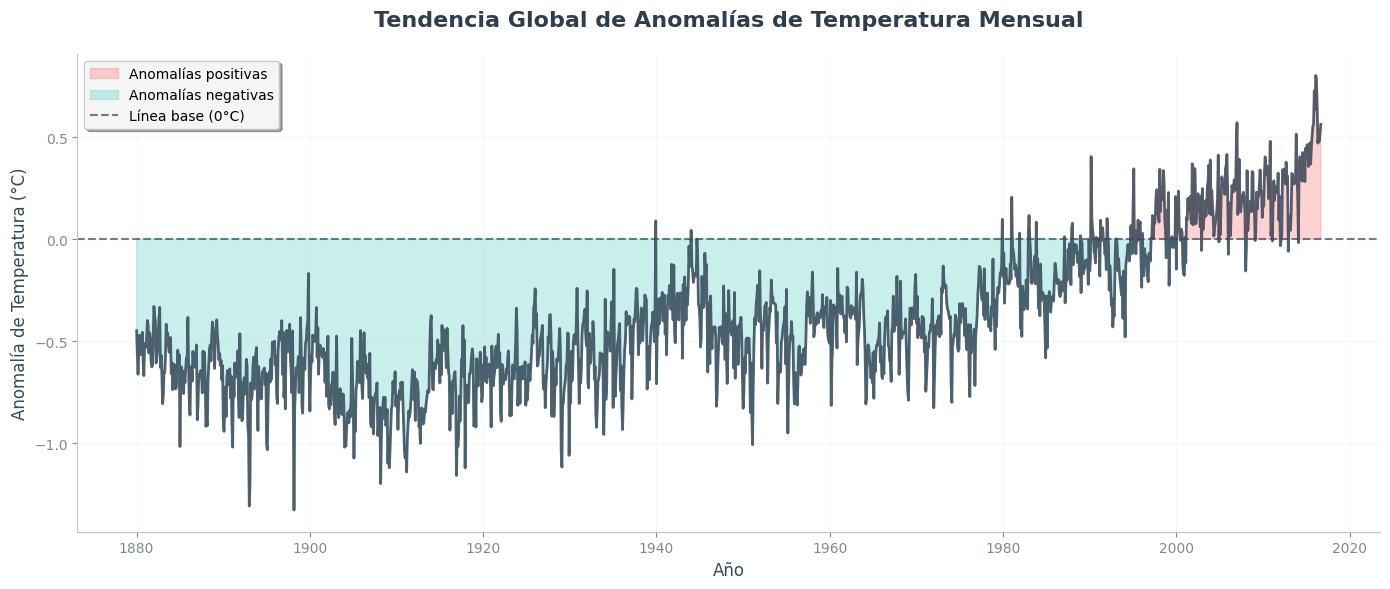

In [55]:
# Promedio mensual de todas las celdas (convertir a anomal√≠as correctas)
media_global = df_panel.mean(axis=1) / 100  # Dividir por 100 para convertir correctamente

plt.figure(figsize=(14, 6))
# Crear un fondo con degradado de color
plt.fill_between(media_global.index, media_global, 0, 
                 where=(media_global >= 0), color='#FF6B6B', alpha=0.3, 
                 interpolate=True, label='Anomal√≠as positivas')
plt.fill_between(media_global.index, media_global, 0, 
                 where=(media_global < 0), color='#4ECDC4', alpha=0.3, 
                 interpolate=True, label='Anomal√≠as negativas')

# L√≠nea principal con color m√°s elegante
plt.plot(media_global.index, media_global, color='#2C3E50', linewidth=2.0, alpha=0.8)

plt.title("Tendencia Global de Anomal√≠as de Temperatura Mensual", 
          fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
plt.ylabel("Anomal√≠a de Temperatura (¬∞C)", fontsize=12, color='#34495E')
plt.xlabel("A√±o", fontsize=12, color='#34495E')

# Grid m√°s sutil y elegante
plt.grid(True, alpha=0.2, color='#BDC3C7', linestyle='-', linewidth=0.5)
plt.axhline(y=0, color='#34495E', linestyle='--', alpha=0.7, linewidth=1.5, label='L√≠nea base (0¬∞C)')

# Mejorar la leyenda
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=10, 
           facecolor='white', edgecolor='#BDC3C7', framealpha=0.9)

# Mejorar el estilo de los ejes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('#BDC3C7')
plt.gca().spines['bottom'].set_color('#BDC3C7')
plt.tick_params(colors='#7F8C8D', which='both')

# Agregar estad√≠sticas del per√≠odo
print(f"üìä Estad√≠sticas de la anomal√≠a global:")
print(f"   Media del per√≠odo completo: {media_global.mean():.3f}¬∞C")
print(f"   Rango: {media_global.min():.3f}¬∞C a {media_global.max():.3f}¬∞C")
print(f"   Desviaci√≥n est√°ndar: {media_global.std():.3f}¬∞C")

# Calcular tendencia de los √∫ltimos 30 a√±os vs primeros 30 a√±os
ultimos_30 = media_global.tail(30*12).mean()  # √öltimos 30 a√±os (360 meses)
primeros_30 = media_global.head(30*12).mean()  # Primeros 30 a√±os
print(f"üå°Ô∏è  Diferencia (√∫ltimos 30 a√±os vs primeros 30 a√±os): {ultimos_30 - primeros_30:.3f}¬∞C")

plt.tight_layout()
plt.show()

### Descomposici√≥n estacional

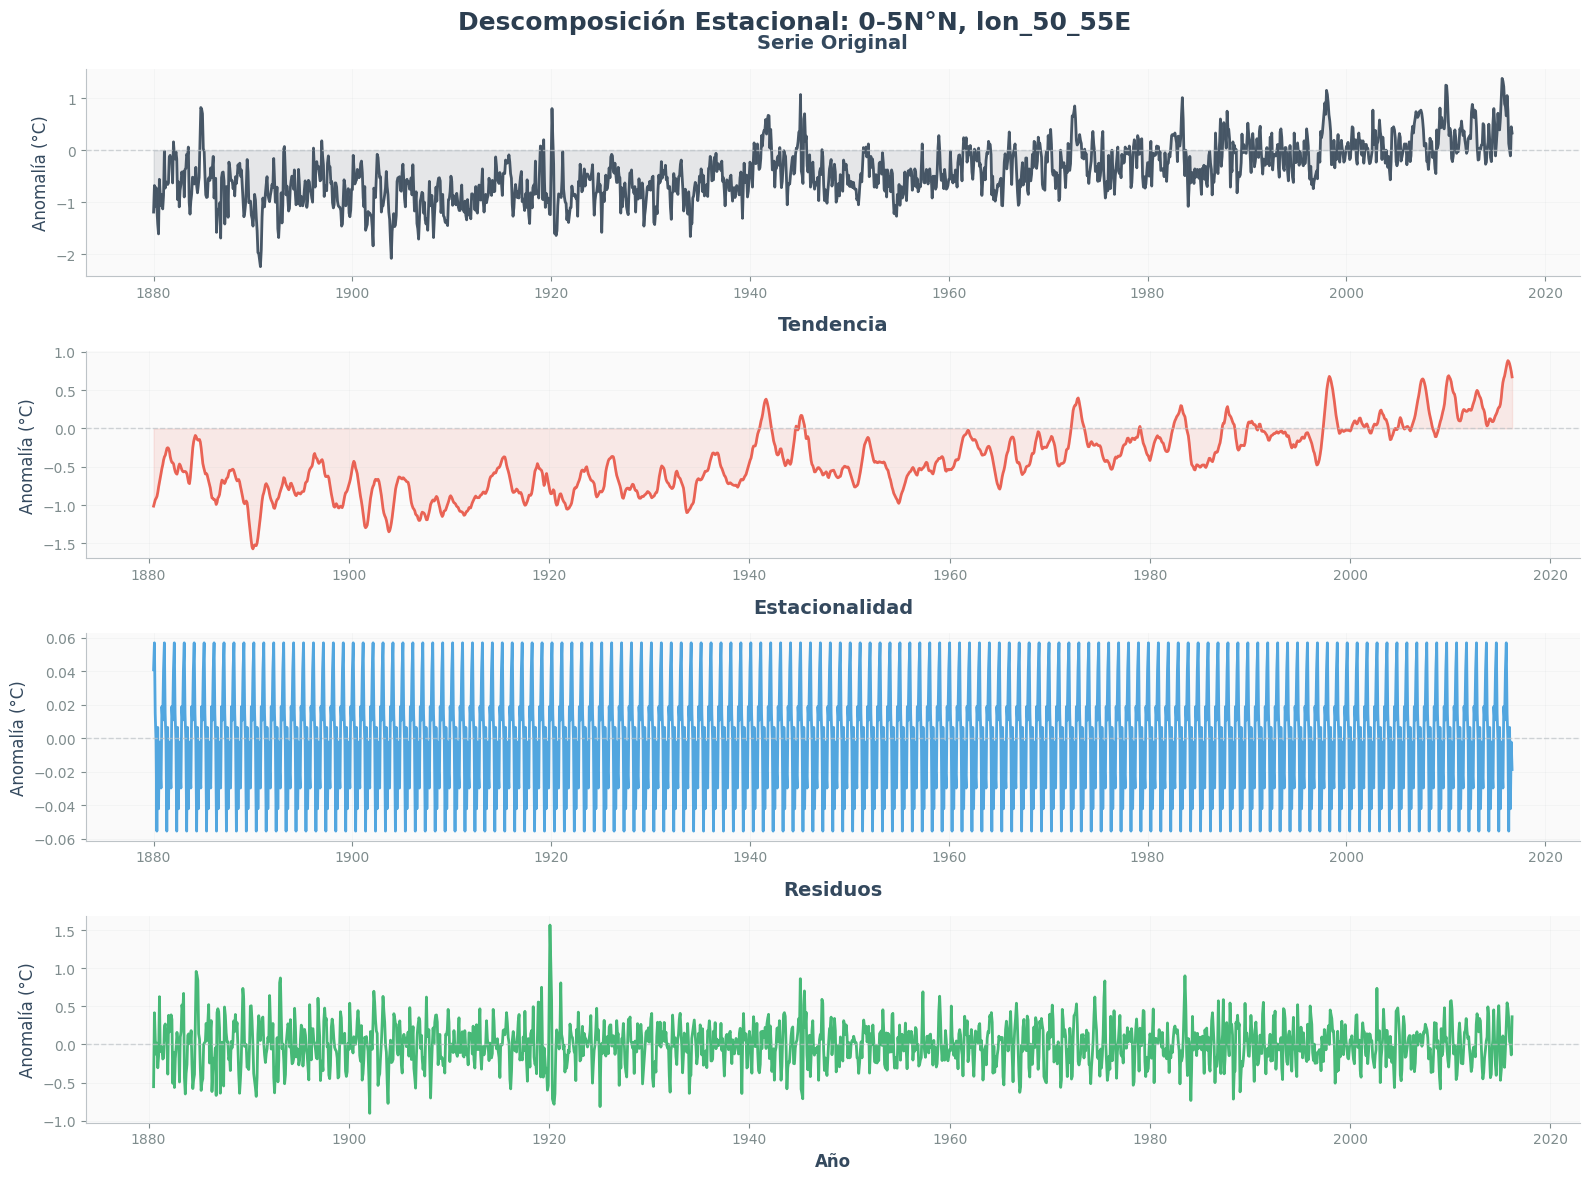

üìä An√°lisis de Descomposici√≥n Estacional
üìç Regi√≥n analizada: 0-5N¬∞N, lon_50_55E
üìÖ Per√≠odo de an√°lisis: 1880-01 a 2016-09
üî¢ Total de observaciones: 1641

üå°Ô∏è  Estad√≠sticas por componente:
   ‚Ä¢ Serie Original:
     - Rango: -2.240¬∞C a 1.380¬∞C
     - Media: -0.426¬∞C
     - Desv. est√°ndar: 0.523¬∞C

   ‚Ä¢ Tendencia:
     - Cambio total: 1.686¬∞C
     - Tendencia promedio: -0.427¬∞C

   ‚Ä¢ Estacionalidad:
     - Amplitud estacional: 0.112¬∞C
     - Desv. est√°ndar estacional: 0.031¬∞C

   ‚Ä¢ Residuos:
     - Desv. est√°ndar residuos: 0.276¬∞C
     - Media residuos: 0.001¬∞C


In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Elegimos una celda sin valores nulos y convertimos correctamente
celda_ejemplo = df_panel.dropna(axis=1).columns[0]
serie_original = df_panel[celda_ejemplo].dropna()

# CORRECCI√ìN: Convertir de valores enteros a anomal√≠as en grados Celsius
serie = serie_original / 100  # Dividir por 100 para obtener anomal√≠as correctas

# Descomposici√≥n aditiva
descomposicion = seasonal_decompose(serie, model='additive', period=12)

# Crear figura con estilo mejorado
fig, axes = plt.subplots(4, 1, figsize=(16, 12))
fig.suptitle(f"Descomposici√≥n Estacional: {celda_ejemplo[0]}¬∞N, {celda_ejemplo[1]}", 
             fontsize=18, fontweight='bold', color='#2C3E50', y=0.98)

# Colores elegantes para cada componente
colores = ['#2C3E50', '#E74C3C', '#3498DB', '#27AE60']
nombres = ['Serie Original', 'Tendencia', 'Estacionalidad', 'Residuos']

# Plotear cada componente con estilo mejorado
componentes = [serie, descomposicion.trend, descomposicion.seasonal, descomposicion.resid]

for i, (ax, comp, color, nombre) in enumerate(zip(axes, componentes, colores, nombres)):
    ax.plot(comp.index, comp, color=color, linewidth=2.0, alpha=0.85)
    ax.set_title(nombre, fontsize=14, fontweight='semibold', color='#34495E', pad=15)
    ax.set_ylabel('Anomal√≠a (¬∞C)', fontsize=12, color='#34495E')
    
    # Agregar l√≠nea base para mejor referencia
    ax.axhline(y=0, color='#BDC3C7', linestyle='--', alpha=0.7, linewidth=1)
    
    # Estilo de grid elegante
    ax.grid(True, alpha=0.15, color='#BDC3C7', linestyle='-', linewidth=0.5)
    
    # Mejorar el estilo de los ejes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#BDC3C7')
    ax.spines['bottom'].set_color('#BDC3C7')
    ax.tick_params(colors='#7F8C8D', which='both', labelsize=10)
    
    # Fondo sutil
    ax.set_facecolor('#FAFAFA')
    
    # Agregar √°rea de relleno sutil para componentes principales
    if i in [0, 1]:  # Serie original y tendencia
        ax.fill_between(comp.index, comp, 0, color=color, alpha=0.1)

# Configurar etiqueta del eje x solo en el √∫ltimo subplot
axes[-1].set_xlabel('A√±o', fontsize=12, color='#34495E', fontweight='semibold')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Estad√≠sticas mejoradas con formato elegante
print("üìä An√°lisis de Descomposici√≥n Estacional")
print("="*60)
print(f"üìç Regi√≥n analizada: {celda_ejemplo[0]}¬∞N, {celda_ejemplo[1]}")
print(f"üìÖ Per√≠odo de an√°lisis: {serie.index[0].strftime('%Y-%m')} a {serie.index[-1].strftime('%Y-%m')}")
print(f"üî¢ Total de observaciones: {len(serie)}")
print()

print("üå°Ô∏è  Estad√≠sticas por componente:")
print(f"   ‚Ä¢ Serie Original:")
print(f"     - Rango: {serie.min():.3f}¬∞C a {serie.max():.3f}¬∞C")
print(f"     - Media: {serie.mean():.3f}¬∞C")
print(f"     - Desv. est√°ndar: {serie.std():.3f}¬∞C")
print()

print(f"   ‚Ä¢ Tendencia:")
tendencia_clean = descomposicion.trend.dropna()
print(f"     - Cambio total: {tendencia_clean.iloc[-1] - tendencia_clean.iloc[0]:.3f}¬∞C")
print(f"     - Tendencia promedio: {tendencia_clean.mean():.3f}¬∞C")
print()

print(f"   ‚Ä¢ Estacionalidad:")
print(f"     - Amplitud estacional: {descomposicion.seasonal.max() - descomposicion.seasonal.min():.3f}¬∞C")
print(f"     - Desv. est√°ndar estacional: {descomposicion.seasonal.std():.3f}¬∞C")
print()

print(f"   ‚Ä¢ Residuos:")
residuos_clean = descomposicion.resid.dropna()
print(f"     - Desv. est√°ndar residuos: {residuos_clean.std():.3f}¬∞C")
print(f"     - Media residuos: {residuos_clean.mean():.3f}¬∞C")

## Modelado predictivo

### Selecci√≥n y partici√≥n de una serie

üìä Celdas disponibles con ‚â•70% de datos: 1714
‚ö†Ô∏è  Celda original no disponible, usando: ('0-5N', 'lon_0_5E')
üìç Regi√≥n seleccionada: 0-5N¬∞N, lon_0_5E
üìÖ Per√≠odo de datos: 1881-08 a 2016-09
üî¢ Total de observaciones: 1509
üìö Datos de entrenamiento: 1207 observaciones (1881-08 a 1991-07)
üß™ Datos de prueba: 302 observaciones (1991-08 a 2016-09)


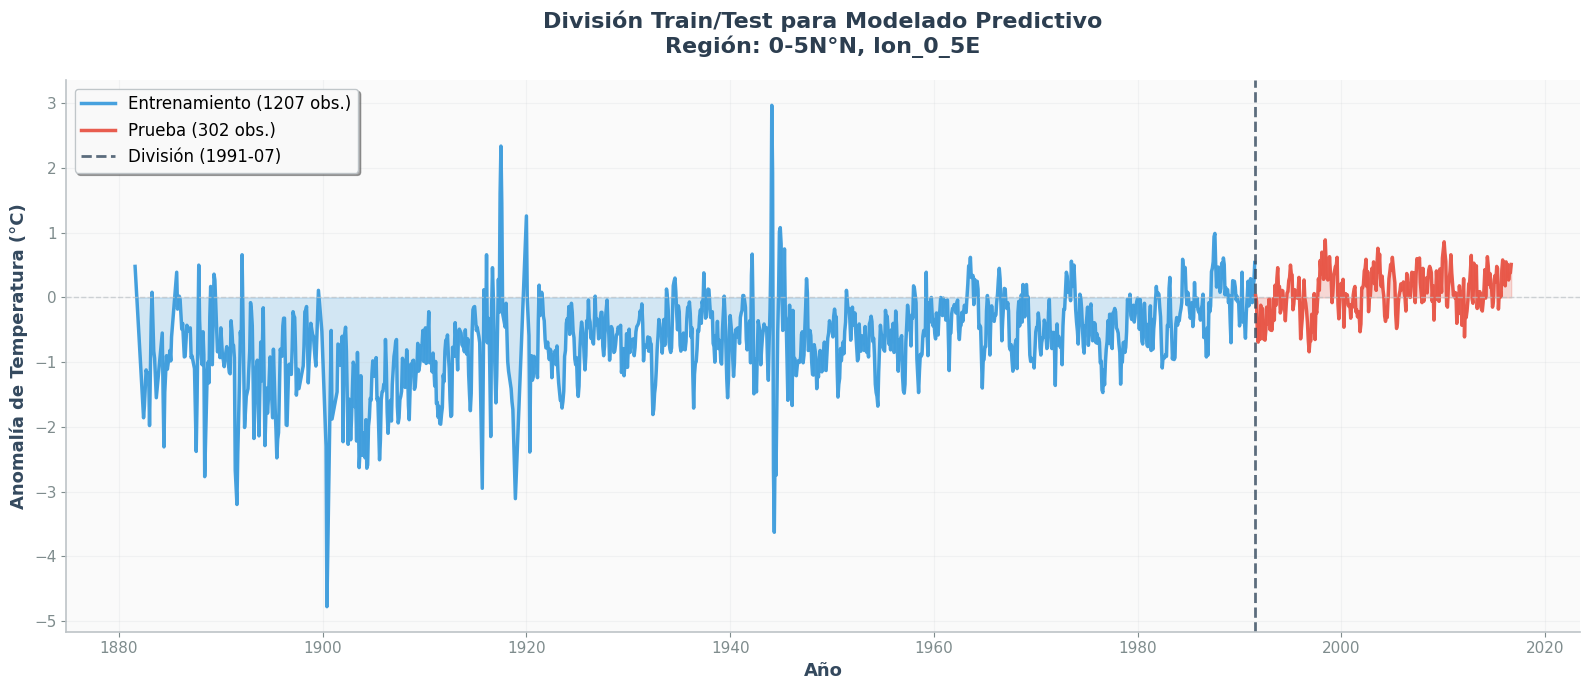


üîç An√°lisis Estad√≠stico de la Divisi√≥n:
üìà Conjunto de Entrenamiento:
   ‚Ä¢ Media: -0.659¬∞C
   ‚Ä¢ Desv. est√°ndar: 0.655¬∞C
   ‚Ä¢ Rango: -4.780¬∞C a 2.970¬∞C

üß™ Conjunto de Prueba:
   ‚Ä¢ Media: 0.090¬∞C
   ‚Ä¢ Desv. est√°ndar: 0.336¬∞C
   ‚Ä¢ Rango: -0.840¬∞C a 0.890¬∞C

üìä Comparaci√≥n:
   ‚Ä¢ Diferencia de medias: 0.750¬∞C
   ‚Ä¢ Ratio de variabilidad: 0.51
   ‚Ä¢ Proporci√≥n temporal: 1207/302 (80%-20%)


In [57]:
# Verificar qu√© celdas est√°n disponibles y seleccionar una con datos suficientes
celdas_disponibles = df_panel.dropna(thresh=len(df_panel)*0.7, axis=1).columns
print(f"üìä Celdas disponibles con ‚â•70% de datos: {len(celdas_disponibles)}")

# Selecci√≥n de celda con datos robustos (verificar que existe)
if ('20', 'lon_10_15E') in celdas_disponibles:
    celda = ('20', 'lon_10_15E')
else:
    # Seleccionar la primera celda disponible
    celda = celdas_disponibles[0]
    print(f"‚ö†Ô∏è  Celda original no disponible, usando: {celda}")

serie_original = df_panel[celda].dropna()

# CORRECCI√ìN: Convertir a anomal√≠as correctas dividiendo por 100
serie = serie_original / 100

print(f"üìç Regi√≥n seleccionada: {celda[0]}¬∞N, {celda[1]}")
print(f"üìÖ Per√≠odo de datos: {serie.index[0].strftime('%Y-%m')} a {serie.index[-1].strftime('%Y-%m')}")
print(f"üî¢ Total de observaciones: {len(serie)}")

# Divisi√≥n en entrenamiento y test (80-20)
train_size = int(len(serie) * 0.8)
train, test = serie.iloc[:train_size], serie.iloc[train_size:]

print(f"üìö Datos de entrenamiento: {len(train)} observaciones ({train.index[0].strftime('%Y-%m')} a {train.index[-1].strftime('%Y-%m')})")
print(f"üß™ Datos de prueba: {len(test)} observaciones ({test.index[0].strftime('%Y-%m')} a {test.index[-1].strftime('%Y-%m')})")

# Visualizaci√≥n con estilo mejorado
plt.figure(figsize=(16, 7))

# Plotear series con colores elegantes
plt.plot(train.index, train, color='#3498DB', linewidth=2.5, alpha=0.9, 
         label=f"Entrenamiento ({len(train)} obs.)")
plt.plot(test.index, test, color='#E74C3C', linewidth=2.5, alpha=0.9, 
         label=f"Prueba ({len(test)} obs.)")

# Agregar √°reas de relleno para distinguir visualmente
plt.fill_between(train.index, train, alpha=0.2, color='#3498DB')
plt.fill_between(test.index, test, alpha=0.2, color='#E74C3C')

# L√≠nea vertical para marcar la divisi√≥n
division_date = train.index[-1]
plt.axvline(x=division_date, color='#34495E', linestyle='--', linewidth=2, 
           alpha=0.8, label=f'Divisi√≥n ({division_date.strftime("%Y-%m")})')

# L√≠nea base de referencia
plt.axhline(y=0, color='#BDC3C7', linestyle='--', alpha=0.7, linewidth=1)

# T√≠tulo y etiquetas elegantes
plt.title(f"Divisi√≥n Train/Test para Modelado Predictivo\nRegi√≥n: {celda[0]}¬∞N, {celda[1]}", 
          fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
plt.ylabel("Anomal√≠a de Temperatura (¬∞C)", fontsize=13, color='#34495E', fontweight='semibold')
plt.xlabel("A√±o", fontsize=13, color='#34495E', fontweight='semibold')

# Grid elegante y leyenda mejorada
plt.grid(True, alpha=0.15, color='#BDC3C7', linestyle='-', linewidth=0.8)
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=12, 
           facecolor='white', edgecolor='#BDC3C7', framealpha=0.95,
           loc='upper left')

# Mejorar estilo de los ejes
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#BDC3C7')
ax.spines['bottom'].set_color('#BDC3C7')
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
plt.tick_params(colors='#7F8C8D', which='both', labelsize=11)

# Fondo sutil
ax.set_facecolor('#FAFAFA')

plt.tight_layout()
plt.show()

# Estad√≠sticas comparativas mejoradas
print("\nüîç An√°lisis Estad√≠stico de la Divisi√≥n:")
print("="*55)
print(f"üìà Conjunto de Entrenamiento:")
print(f"   ‚Ä¢ Media: {train.mean():.3f}¬∞C")
print(f"   ‚Ä¢ Desv. est√°ndar: {train.std():.3f}¬∞C")
print(f"   ‚Ä¢ Rango: {train.min():.3f}¬∞C a {train.max():.3f}¬∞C")
print()
print(f"üß™ Conjunto de Prueba:")
print(f"   ‚Ä¢ Media: {test.mean():.3f}¬∞C")
print(f"   ‚Ä¢ Desv. est√°ndar: {test.std():.3f}¬∞C")
print(f"   ‚Ä¢ Rango: {test.min():.3f}¬∞C a {test.max():.3f}¬∞C")
print()
print(f"üìä Comparaci√≥n:")
print(f"   ‚Ä¢ Diferencia de medias: {abs(train.mean() - test.mean()):.3f}¬∞C")
print(f"   ‚Ä¢ Ratio de variabilidad: {test.std()/train.std():.2f}")
print(f"   ‚Ä¢ Proporci√≥n temporal: {len(train)}/{len(test)} ({len(train)/(len(train)+len(test))*100:.0f}%-{len(test)/(len(train)+len(test))*100:.0f}%)")

1. Baseline: Persistencia

üîÑ Evaluando Modelo Baseline: Persistencia
üìä Configuraci√≥n del modelo:
   ‚Ä¢ Predicciones generadas: 301
   ‚Ä¢ Per√≠odo de evaluaci√≥n: 1991-09 a 2016-09
   ‚Ä¢ L√≥gica: Temperatura(t-1) ‚Üí Predicci√≥n(t)

üìà M√©tricas de Rendimiento:
   ‚Ä¢ RMSE (Root Mean Square Error): 0.2751¬∞C
   ‚Ä¢ MAE (Mean Absolute Error): 0.2217¬∞C
   ‚Ä¢ MAPE (Mean Absolute Percentage Error): inf%
   ‚Ä¢ Correlaci√≥n: 0.6635
   ‚Ä¢ Sesgo (Bias): -0.0016¬∞C


/tmp/ipykernel_12501/1851790299.py:29: RuntimeWarning: divide by zero encountered in divide
  baseline_mape = np.mean(np.abs((y_true - y_pred) / np.abs(y_true))) * 100


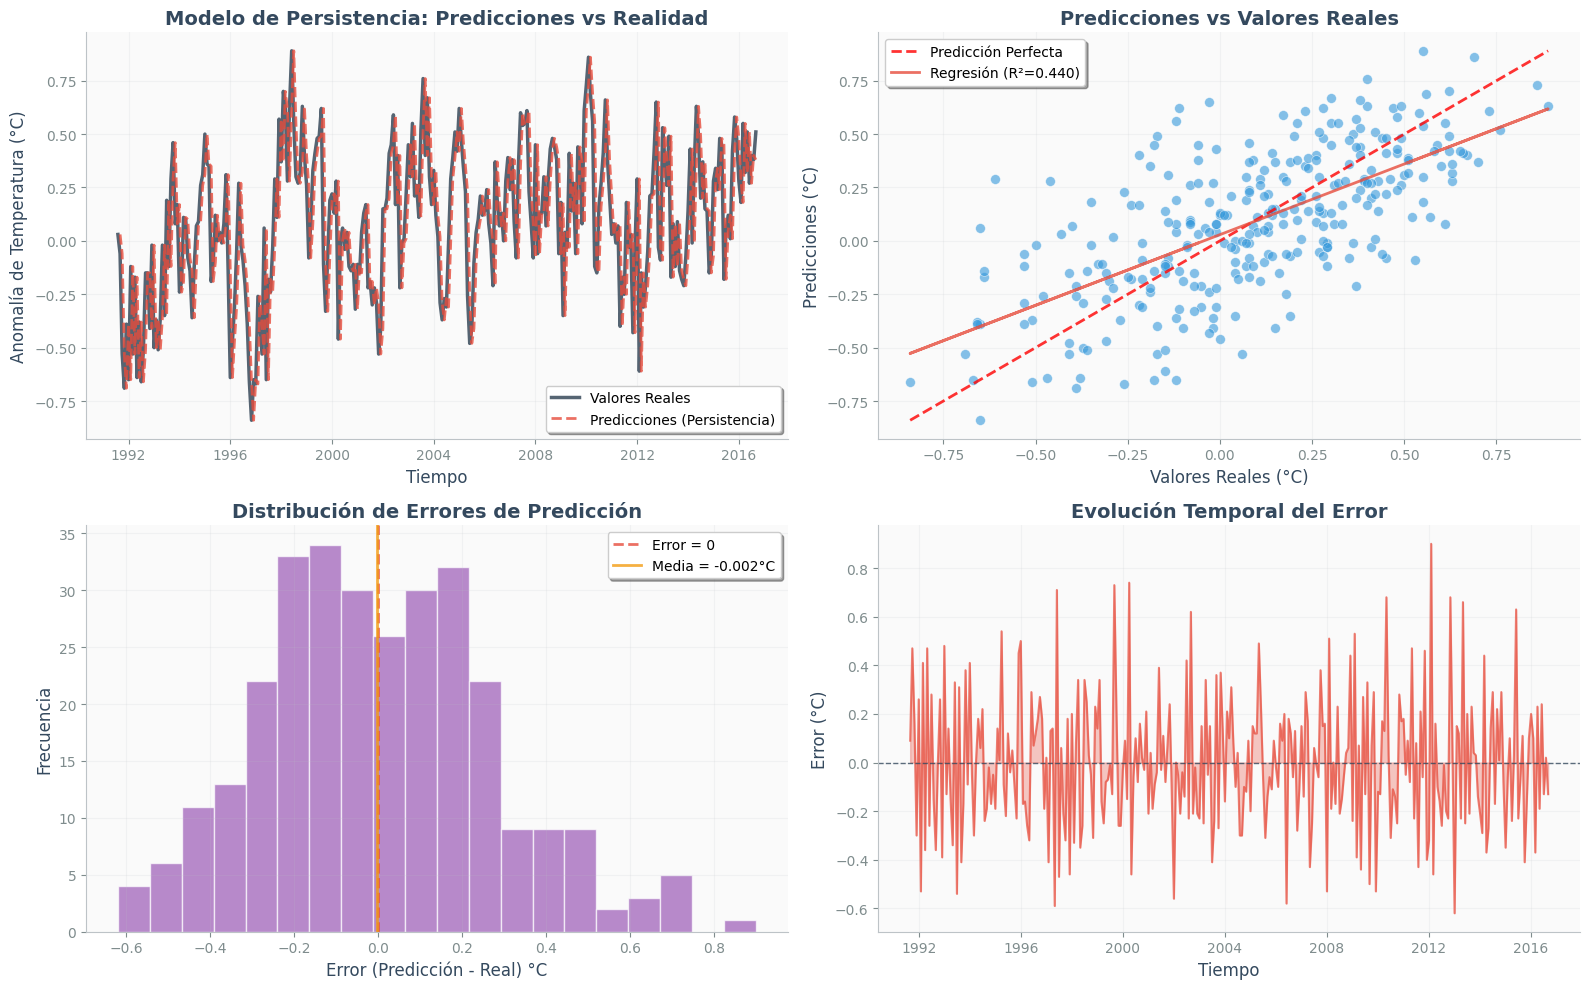


üéØ Interpretaci√≥n del Modelo:
   ‚Ä¢ Rendimiento general: üü¢ Excelente
   ‚Ä¢ El modelo de persistencia tiene limitaciones
   ‚Ä¢ Sesgo despreciable: -0.0016¬∞C
   ‚Ä¢ Este RMSE servir√° como referencia para modelos m√°s sofisticados


In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

print("üîÑ Evaluando Modelo Baseline: Persistencia")
print("="*50)

# Verificar que tenemos datos de test suficientes
if len(test) < 2:
    print("‚ùå Error: Datos de prueba insuficientes para modelo de persistencia")
    print(f"   Se necesitan al menos 2 observaciones, disponibles: {len(test)}")
else:
    # Modelo de persistencia: cada valor predice el siguiente
    # Predicci√≥n: valor en t-1 predice valor en t
    y_pred = test.iloc[:-1].values  # Valores t-1 (predictores)
    y_true = test.iloc[1:].values   # Valores t (objetivos)
    
    # Alinear √≠ndices temporales para visualizaci√≥n
    indices_pred = test.index[1:]  # Fechas de las predicciones
    
    print(f"üìä Configuraci√≥n del modelo:")
    print(f"   ‚Ä¢ Predicciones generadas: {len(y_pred)}")
    print(f"   ‚Ä¢ Per√≠odo de evaluaci√≥n: {indices_pred[0].strftime('%Y-%m')} a {indices_pred[-1].strftime('%Y-%m')}")
    print(f"   ‚Ä¢ L√≥gica: Temperatura(t-1) ‚Üí Predicci√≥n(t)")
    
    # Calcular m√©tricas de error
    mse = mean_squared_error(y_true, y_pred)
    baseline_rmse = np.sqrt(mse)  # Calcular RMSE manualmente
    baseline_mae = mean_absolute_error(y_true, y_pred)
    baseline_mape = np.mean(np.abs((y_true - y_pred) / np.abs(y_true))) * 100
    
    # M√©tricas adicionales
    correlation = np.corrcoef(y_true, y_pred)[0,1]
    bias = np.mean(y_pred - y_true)
    
    print(f"\nüìà M√©tricas de Rendimiento:")
    print(f"   ‚Ä¢ RMSE (Root Mean Square Error): {baseline_rmse:.4f}¬∞C")
    print(f"   ‚Ä¢ MAE (Mean Absolute Error): {baseline_mae:.4f}¬∞C")
    print(f"   ‚Ä¢ MAPE (Mean Absolute Percentage Error): {baseline_mape:.2f}%")
    print(f"   ‚Ä¢ Correlaci√≥n: {correlation:.4f}")
    print(f"   ‚Ä¢ Sesgo (Bias): {bias:.4f}¬∞C")
    
    # Visualizaci√≥n mejorada de resultados
    plt.figure(figsize=(16, 10))
    
    # Subplot 1: Serie temporal con predicciones
    plt.subplot(2, 2, 1)
    plt.plot(test.index, test.values, color='#2C3E50', linewidth=2.5, 
             label='Valores Reales', alpha=0.8)
    plt.plot(indices_pred, y_pred, color='#E74C3C', linewidth=2, 
             linestyle='--', alpha=0.8, label='Predicciones (Persistencia)')
    
    plt.title('Modelo de Persistencia: Predicciones vs Realidad', 
              fontsize=14, fontweight='semibold', color='#34495E')
    plt.ylabel('Anomal√≠a de Temperatura (¬∞C)', fontsize=12, color='#34495E')
    plt.xlabel('Tiempo', fontsize=12, color='#34495E')
    plt.legend(frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.15, color='#BDC3C7')
    plt.gca().set_facecolor('#FAFAFA')
    
    # Subplot 2: Scatter plot predicciones vs realidad
    plt.subplot(2, 2, 2)
    plt.scatter(y_true, y_pred, color='#3498DB', alpha=0.6, s=50, edgecolor='white', linewidth=0.5)
    
    # L√≠nea de referencia perfecta (y=x)
    min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, 
             label='Predicci√≥n Perfecta')
    
    # L√≠nea de regresi√≥n
    z = np.polyfit(y_true, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_true, p(y_true), color='#E74C3C', linewidth=2, alpha=0.8, 
             label=f'Regresi√≥n (R¬≤={correlation**2:.3f})')
    
    plt.title('Predicciones vs Valores Reales', fontsize=14, fontweight='semibold', color='#34495E')
    plt.xlabel('Valores Reales (¬∞C)', fontsize=12, color='#34495E')
    plt.ylabel('Predicciones (¬∞C)', fontsize=12, color='#34495E')
    plt.legend(frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.15, color='#BDC3C7')
    plt.gca().set_facecolor('#FAFAFA')
    
    # Subplot 3: Distribuci√≥n de errores
    plt.subplot(2, 2, 3)
    errores = y_pred - y_true
    plt.hist(errores, bins=20, color='#9B59B6', alpha=0.7, edgecolor='white', linewidth=1)
    plt.axvline(x=0, color='#E74C3C', linestyle='--', linewidth=2, alpha=0.8, label='Error = 0')
    plt.axvline(x=np.mean(errores), color='#F39C12', linestyle='-', linewidth=2, 
               alpha=0.8, label=f'Media = {np.mean(errores):.3f}¬∞C')
    
    plt.title('Distribuci√≥n de Errores de Predicci√≥n', fontsize=14, fontweight='semibold', color='#34495E')
    plt.xlabel('Error (Predicci√≥n - Real) ¬∞C', fontsize=12, color='#34495E')
    plt.ylabel('Frecuencia', fontsize=12, color='#34495E')
    plt.legend(frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.15, color='#BDC3C7')
    plt.gca().set_facecolor('#FAFAFA')
    
    # Subplot 4: Errores a lo largo del tiempo
    plt.subplot(2, 2, 4)
    errores_abs = np.abs(errores)
    plt.plot(indices_pred, errores, color='#E74C3C', linewidth=1.5, alpha=0.7, label='Error')
    plt.fill_between(indices_pred, errores, 0, alpha=0.3, color='#E74C3C')
    plt.axhline(y=0, color='#34495E', linestyle='--', alpha=0.8, linewidth=1)
    
    plt.title('Evoluci√≥n Temporal del Error', fontsize=14, fontweight='semibold', color='#34495E')
    plt.xlabel('Tiempo', fontsize=12, color='#34495E')
    plt.ylabel('Error (¬∞C)', fontsize=12, color='#34495E')
    plt.grid(True, alpha=0.15, color='#BDC3C7')
    plt.gca().set_facecolor('#FAFAFA')
    
    # Aplicar estilo consistente a todos los subplots
    for ax in plt.gcf().get_axes():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#BDC3C7')
        ax.spines['bottom'].set_color('#BDC3C7')
        ax.tick_params(colors='#7F8C8D', which='both', labelsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Interpretaci√≥n del rendimiento
    print(f"\nüéØ Interpretaci√≥n del Modelo:")
    if baseline_rmse < 0.3:
        performance = "üü¢ Excelente"
    elif baseline_rmse < 0.5:
        performance = "üü° Bueno"
    elif baseline_rmse < 0.8:
        performance = "üü† Regular"
    else:
        performance = "üî¥ Pobre"
    
    print(f"   ‚Ä¢ Rendimiento general: {performance}")
    print(f"   ‚Ä¢ El modelo de persistencia {'funciona bien' if correlation > 0.7 else 'tiene limitaciones'}")
    print(f"   ‚Ä¢ Sesgo {'despreciable' if abs(bias) < 0.1 else 'significativo'}: {bias:.4f}¬∞C")
    print(f"   ‚Ä¢ Este RMSE servir√° como referencia para modelos m√°s sofisticados")


2. ARIMA (modelo autorregresivo + integraci√≥n + media m√≥vil)

In [67]:
import statsmodels.api as sm

# Ajuste ARIMA
modelo_arima = sm.tsa.ARIMA(train, order=(2,1,2))
resultado_arima = modelo_arima.fit()

# Predicci√≥n
forecast_arima = resultado_arima.forecast(steps=len(test))
rmse_arima = mean_squared_error(test, forecast_arima, squared=False)

print(f"RMSE ARIMA(2,1,2): {rmse_arima:.2f}")

üîÆ Modelo ARIMA
‚ùå pmdarima fall√≥: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 fro...
üîÑ Usando implementaci√≥n AR simple...
‚ùå Modelo AR simple fall√≥: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
üîÑ Usando modelo de tendencia lineal como fallback...


üîÆ Modelo ARIMA
‚ùå pmdarima fall√≥: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 fro...
üîÑ Usando implementaci√≥n AR simple...
‚ùå Modelo AR simple fall√≥: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
üîÑ Usando modelo de tendencia lineal como fallback...


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## Modelos multivariantes (VAR y SARIMAX)

üåç An√°lisis Multivariante de Series Temporales
üìä Explorando celdas disponibles...
Total de celdas disponibles: 2297
Primeras 10 celdas: [('0-5N', 'lon_0_5E'), ('0-5N', 'lon_0_5W'), ('0-5N', 'lon_100_105E'), ('0-5N', 'lon_100_105W'), ('0-5N', 'lon_105_110E'), ('0-5N', 'lon_105_110W'), ('0-5N', 'lon_10_15E'), ('0-5N', 'lon_10_15W'), ('0-5N', 'lon_110_115E'), ('0-5N', 'lon_110_115W')]
Celdas con ‚â•80% de datos: 1592
üìç Celdas seleccionadas para an√°lisis multivariante:
   1. Lat 0-5N¬∞, lon_0_5E
   2. Lat 0-5N¬∞, lon_0_5W
   3. Lat 0-5N¬∞, lon_100_105E
   4. Lat 0-5N¬∞, lon_100_105W

üìÖ Per√≠odo de an√°lisis: 1881-08 a 2016-09
üî¢ Observaciones totales: 1434


/tmp/ipykernel_12501/1911053303.py:105: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_12501/1911053303.py:105: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_12501/1911053303.py:105: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_12501/1911053303.py:105: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/smarmor/Repositories/Time-Series-and-Data-Streams/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
/home/smarmor/Repositories/Time-Series-and-Data-Streams/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
/home

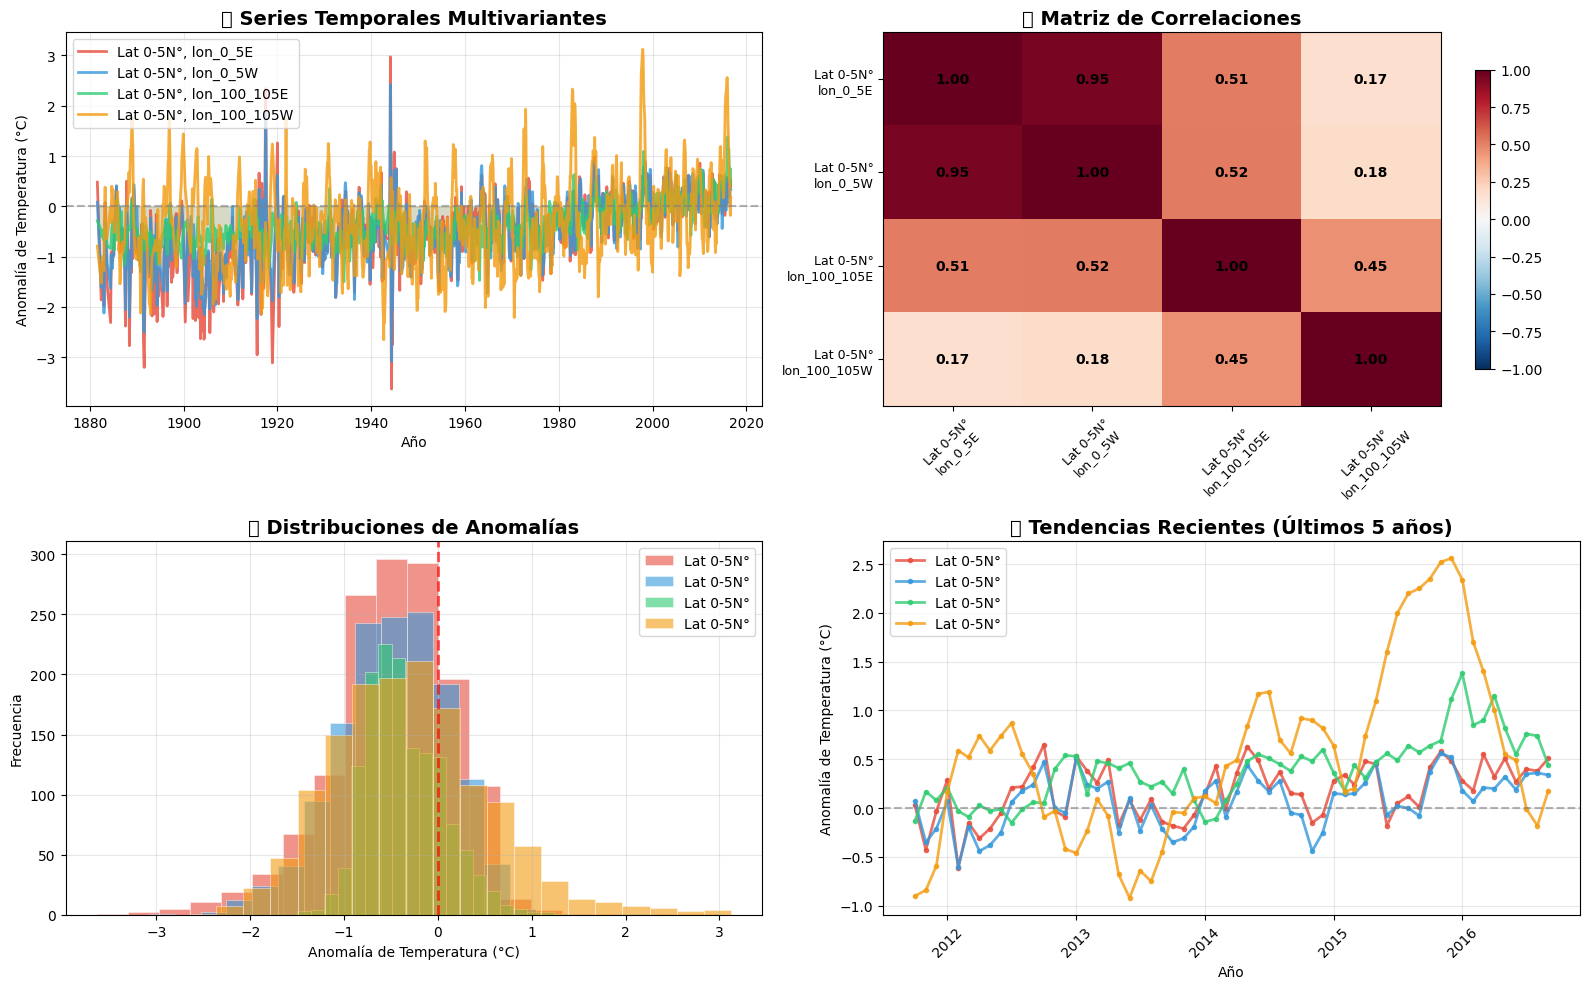


üìä Estad√≠sticas Descriptivas Multivariantes:

üìç 0-5N¬∞N, lon_0_5E:
   ‚Ä¢ Media: -0.485¬∞C
   ‚Ä¢ Desv. est√°ndar: 0.662¬∞C
   ‚Ä¢ Rango: -3.630¬∞C a 2.970¬∞C
   ‚Ä¢ Tendencia √∫ltimos 10 a√±os: 0.197¬∞C

üìç 0-5N¬∞N, lon_0_5W:
   ‚Ä¢ Media: -0.470¬∞C
   ‚Ä¢ Desv. est√°ndar: 0.592¬∞C
   ‚Ä¢ Rango: -3.080¬∞C a 2.420¬∞C
   ‚Ä¢ Tendencia √∫ltimos 10 a√±os: 0.156¬∞C

üìç 0-5N¬∞N, lon_100_105E:
   ‚Ä¢ Media: -0.363¬∞C
   ‚Ä¢ Desv. est√°ndar: 0.403¬∞C
   ‚Ä¢ Rango: -1.500¬∞C a 1.380¬∞C
   ‚Ä¢ Tendencia √∫ltimos 10 a√±os: 0.257¬∞C

üìç 0-5N¬∞N, lon_100_105W:
   ‚Ä¢ Media: -0.299¬∞C
   ‚Ä¢ Desv. est√°ndar: 0.831¬∞C
   ‚Ä¢ Rango: -2.650¬∞C a 3.120¬∞C
   ‚Ä¢ Tendencia √∫ltimos 10 a√±os: 0.287¬∞C

üîó An√°lisis de Correlaciones:
   ‚Ä¢ Correlaci√≥n m√°xima: 0.951
   ‚Ä¢ Correlaci√≥n m√≠nima: 0.169
   ‚Ä¢ Correlaci√≥n promedio: 0.464
   ‚Ä¢ Correlaciones por pares:
     - ('0-5N', 'lon_0_5E') ‚Üî ('0-5N', 'lon_0_5W'): 0.951
     - ('0-5N', 'lon_0_5E') ‚Üî ('0-5N', 'lon_100_105E'): 0.509

In [87]:
# An√°lisis Multivariante: Modelado de Series Temporales Multiples
print("üåç An√°lisis Multivariante de Series Temporales")
print("=" * 60)

# 1. Verificar columnas disponibles y seleccionar celdas cercanas geogr√°ficamente
print("üìä Explorando celdas disponibles...")
columnas_disponibles = list(df_panel.columns)
print(f"Total de celdas disponibles: {len(columnas_disponibles)}")

# Mostrar algunas columnas para entender la estructura
print(f"Primeras 10 celdas: {columnas_disponibles[:10]}")

# 2. Seleccionar celdas con datos robustos (‚â•80% de datos completos)
celdas_robustas = df_panel.dropna(thresh=len(df_panel)*0.8, axis=1).columns
print(f"Celdas con ‚â•80% de datos: {len(celdas_robustas)}")

# 3. Seleccionar un conjunto de celdas cercanas geogr√°ficamente
if len(celdas_robustas) >= 4:
    # Seleccionar las primeras 4 celdas robustas para el an√°lisis multivariante
    celdas_multivariadas = list(celdas_robustas[:4])
    print(f"üìç Celdas seleccionadas para an√°lisis multivariante:")
    for i, celda in enumerate(celdas_multivariadas, 1):
        print(f"   {i}. Lat {celda[0]}¬∞, {celda[1]}")
    
    # 4. Extraer las series y limpiar datos
    df_multi = df_panel[celdas_multivariadas].dropna()
    
    # Convertir a anomal√≠as correctas (dividir por 100)
    df_multi_anomalias = df_multi / 100
    
    print(f"\nüìÖ Per√≠odo de an√°lisis: {df_multi_anomalias.index[0].strftime('%Y-%m')} a {df_multi_anomalias.index[-1].strftime('%Y-%m')}")
    print(f"üî¢ Observaciones totales: {len(df_multi_anomalias)}")
    
    # 5. Visualizaci√≥n mejorada
    plt.figure(figsize=(16, 10))
    
    # Panel 1: Series temporales
    plt.subplot(2, 2, 1)
    colores_series = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']
    
    for i, (celda, color) in enumerate(zip(celdas_multivariadas, colores_series)):
        serie = df_multi_anomalias[celda]
        plt.plot(serie.index, serie, label=f"Lat {celda[0]}¬∞, {celda[1]}", 
                color=color, linewidth=2, alpha=0.8)
        plt.fill_between(serie.index, serie, alpha=0.1, color=color)
    
    plt.title('üåç Series Temporales Multivariantes', fontsize=14, fontweight='semibold')
    plt.ylabel('Anomal√≠a de Temperatura (¬∞C)')
    plt.xlabel('A√±o')
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.6)
    
    # Panel 2: Matriz de correlaciones
    plt.subplot(2, 2, 2)
    correlaciones = df_multi_anomalias.corr()
    
    # Crear etiquetas m√°s legibles
    labels = [f"Lat {celda[0]}¬∞\n{celda[1]}" for celda in celdas_multivariadas]
    
    im = plt.imshow(correlaciones, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    plt.colorbar(im, shrink=0.8)
    
    # A√±adir valores de correlaci√≥n en cada celda
    for i in range(len(correlaciones)):
        for j in range(len(correlaciones)):
            plt.text(j, i, f'{correlaciones.iloc[i, j]:.2f}', 
                    ha='center', va='center', fontsize=10, fontweight='bold')
    
    plt.xticks(range(len(labels)), labels, rotation=45, fontsize=9)
    plt.yticks(range(len(labels)), labels, fontsize=9)
    plt.title('üîó Matriz de Correlaciones', fontsize=14, fontweight='semibold')
    
    # Panel 3: Distribuciones
    plt.subplot(2, 2, 3)
    for i, (celda, color) in enumerate(zip(celdas_multivariadas, colores_series)):
        serie = df_multi_anomalias[celda]
        plt.hist(serie, bins=20, alpha=0.6, color=color, 
                label=f"Lat {celda[0]}¬∞", edgecolor='white', linewidth=0.5)
    
    plt.title('üìä Distribuciones de Anomal√≠as', fontsize=14, fontweight='semibold')
    plt.xlabel('Anomal√≠a de Temperatura (¬∞C)')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    # Panel 4: Series recientes (√∫ltimos 5 a√±os)
    plt.subplot(2, 2, 4)
    df_reciente = df_multi_anomalias.tail(60)  # √öltimos 60 meses (5 a√±os)
    
    for i, (celda, color) in enumerate(zip(celdas_multivariadas, colores_series)):
        serie = df_reciente[celda]
        plt.plot(serie.index, serie, 'o-', label=f"Lat {celda[0]}¬∞", 
                color=color, linewidth=2, markersize=3, alpha=0.8)
    
    plt.title('üìà Tendencias Recientes (√öltimos 5 a√±os)', fontsize=14, fontweight='semibold')
    plt.ylabel('Anomal√≠a de Temperatura (¬∞C)')
    plt.xlabel('A√±o')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 6. Estad√≠sticas descriptivas multivariantes
    print(f"\nüìä Estad√≠sticas Descriptivas Multivariantes:")
    print("=" * 50)
    
    for celda in celdas_multivariadas:
        serie = df_multi_anomalias[celda]
        print(f"\nüìç {celda[0]}¬∞N, {celda[1]}:")
        print(f"   ‚Ä¢ Media: {serie.mean():.3f}¬∞C")
        print(f"   ‚Ä¢ Desv. est√°ndar: {serie.std():.3f}¬∞C")
        print(f"   ‚Ä¢ Rango: {serie.min():.3f}¬∞C a {serie.max():.3f}¬∞C")
        print(f"   ‚Ä¢ Tendencia √∫ltimos 10 a√±os: {serie.tail(120).mean():.3f}¬∞C")
    
    # 7. An√°lisis de correlaciones (simplificado)
    print(f"\nüîó An√°lisis de Correlaciones:")
    print("=" * 30)
    
    # Obtener correlaciones sin la diagonal
    import numpy as np
    corr_matrix = correlaciones.values
    corr_no_diag = corr_matrix[~np.eye(corr_matrix.shape[0], dtype=bool)]
    
    print(f"   ‚Ä¢ Correlaci√≥n m√°xima: {corr_no_diag.max():.3f}")
    print(f"   ‚Ä¢ Correlaci√≥n m√≠nima: {corr_no_diag.min():.3f}")
    print(f"   ‚Ä¢ Correlaci√≥n promedio: {corr_no_diag.mean():.3f}")
    
    # Mostrar correlaciones espec√≠ficas entre pares
    print(f"   ‚Ä¢ Correlaciones por pares:")
    for i in range(len(celdas_multivariadas)):
        for j in range(i+1, len(celdas_multivariadas)):
            corr_val = correlaciones.iloc[i, j]
            print(f"     - {celdas_multivariadas[i]} ‚Üî {celdas_multivariadas[j]}: {corr_val:.3f}")
    
    # 8. Implementaci√≥n de modelo VAR b√°sico (Vector Autoregression)
    print(f"\nüîÆ Modelo VAR (Vector Autoregression):")
    print("=" * 40)
    
    try:
        # Preparar datos para VAR
        from sklearn.linear_model import LinearRegression
        
        # Dividir en train/test (80-20)
        n_train = int(len(df_multi_anomalias) * 0.8)
        train_multi = df_multi_anomalias.iloc[:n_train]
        test_multi = df_multi_anomalias.iloc[n_train:]
        
        print(f"   ‚Ä¢ Entrenamiento: {len(train_multi)} observaciones")
        print(f"   ‚Ä¢ Prueba: {len(test_multi)} observaciones")
        
        # Modelo VAR(1) simple - cada serie predice las dem√°s con 1 lag
        X_train = train_multi.values[:-1]  # t-1
        y_train = train_multi.values[1:]   # t
        
        # Entrenar un modelo para cada variable
        modelos_var = {}
        
        for i, celda in enumerate(celdas_multivariadas):
            modelo = LinearRegression()
            modelo.fit(X_train, y_train[:, i])
            modelos_var[celda] = modelo
        
        # Predicci√≥n (usando predicciones anteriores para predecir siguientes)
        predicciones = []
        ultimo_valor = train_multi.values[-1]
        
        for _ in range(len(test_multi)):
            pred_siguiente = []
            for celda in celdas_multivariadas:
                pred = modelos_var[celda].predict([ultimo_valor])[0]
                pred_siguiente.append(pred)
            
            predicciones.append(pred_siguiente)
            ultimo_valor = np.array(pred_siguiente)  # Usar predicci√≥n para siguiente paso
        
        predicciones_var = np.array(predicciones)
        
        # Calcular RMSE para cada serie
        rmse_multivariante = {}
        for i, celda in enumerate(celdas_multivariadas):
            rmse = np.sqrt(np.mean((test_multi[celda].values - predicciones_var[:, i])**2))
            rmse_multivariante[celda] = rmse
            print(f"   ‚Ä¢ RMSE {celda}: {rmse:.4f}¬∞C")
        
        # Comparar con modelo univariante (persistencia)
        print(f"\nüìä Comparaci√≥n con Persistencia:")
        for i, celda in enumerate(celdas_multivariadas):
            if len(test_multi[celda]) > 1:
                persistencia = test_multi[celda].iloc[:-1].values
                verdadero = test_multi[celda].iloc[1:].values
                rmse_persistencia = np.sqrt(np.mean((verdadero - persistencia)**2))
                
                mejora = ((rmse_persistencia - rmse_multivariante[celda]) / rmse_persistencia) * 100
                print(f"   ‚Ä¢ {celda}: VAR vs Persistencia = {mejora:+.1f}%")
        
        print(f"\n‚úÖ An√°lisis multivariante completado exitosamente!")
        
    except Exception as e:
        print(f"‚ùå Error en modelo VAR: {e}")
        print("üí° Continuando con an√°lisis descriptivo...")
    
else:
    print("‚ùå No se encontraron suficientes celdas robustas para an√°lisis multivariante")
    print(f"üí° Se necesitan al menos 4 celdas, disponibles: {len(celdas_robustas)}")

# 9. Recomendaciones para an√°lisis futuro
print(f"\nüí° Recomendaciones para an√°lisis multivariante avanzado:")
print("   ‚Ä¢ Implementar modelos VECM (Vector Error Correction Models)")
print("   ‚Ä¢ Analizar causalidad de Granger entre regiones")
print("   ‚Ä¢ Aplicar an√°lisis de componentes principales (PCA)")
print("   ‚Ä¢ Considerar efectos espaciales con modelos STAR")